# 결정 트리
## 개요
- 분류, 회귀, 다중 출력 작업까지 가능한 다목적 머신러닝 알고리즘 
- 복잡한 데이터 셋 학습도 가능 
- 랜덤 포레스트 의 기본 구성 요소 

### 화이트 박스 모델 
- 결정 트리는 직관적이고 이해하기 쉬움 -> 화이트 박스 모델 
- 신경망 혹은 랜덤포레스트 같이 이해하기 어려움 -> 블랙박스 모델 

# 1. 결정 트리 학습과 시각화 

- 예시 : 붓꽃 데이터셋의 DecisionTreeClassifier 모델 훈련 

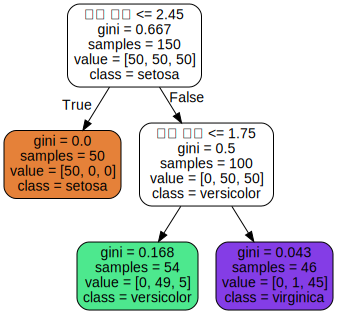

In [1]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source

### 데이터셋 로드 
iris = load_iris(as_frame=True)
### 매개변수 선택 - 꽃잎 길이 및 너비 
X_iris = iris.data[['petal length (cm)', 'petal width (cm)']].values
### 타겟데이터 
y_iris = iris.target

### 분류기 선언 
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)

### 모델 학습 
tree_clf.fit(X_iris, y_iris)

### 시각화
export_graphviz(
    tree_clf,
    out_file = "iris_tree.dot",
    feature_names = ["꽃잎 길이","꽃잎 너비"],
    class_names = iris.target_names,
    rounded = True,
    filled=True
)

Source.from_file("iris_tree.dot")

# 2. 예측 

## 결정트리의 구조 
- `루트 노드` : 깊이가 0인 꼭대기 노드 
- `리프 노드` : 자식 노드가 없는 마지막 노드 
- `분할 노드` : 자식 노드가 있고 깊이가 0이 아닌 노드 
- `sample` : 얼마나 많은 훈련 샘플이 적용되었는지 
- `value` : 각 클래스에 얼마나 많은 샘플이 있는지 
- `지니불순도(gini)` : 데이터 집합의 불순도 

### 지니 불순도 
- 모든 샘플이 같은 클래스에 속해 있다면 순수 (gini=0) 
- $G_i = 1 - \displaystyle\sum_{k=1}^n p_{i,k}^2$
- $G_i$ : i번째 노드의 지니 불순도 
- $p_{i,k}^2$ : i번째 노드에 있는 훈련 샘플 중 클래스 k에 속한 샘플 비율 

- 결정 트리의 결정 경계 예시 

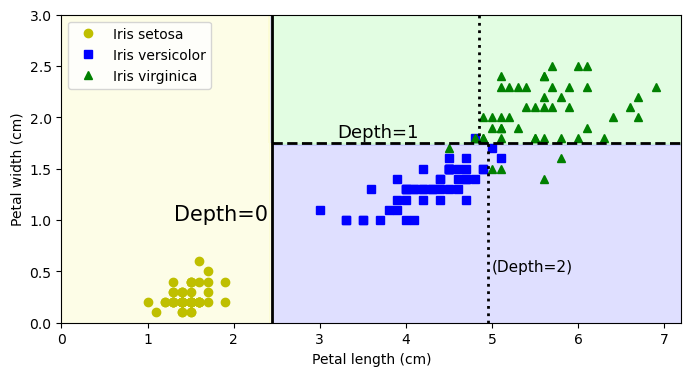

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])
plt.figure(figsize=(8, 4))

lengths, widths = np.meshgrid(np.linspace(0, 7.2, 100), np.linspace(0, 3, 100))
X_iris_all = np.c_[lengths.ravel(), widths.ravel()]
y_pred = tree_clf.predict(X_iris_all).reshape(lengths.shape)
plt.contourf(lengths, widths, y_pred, alpha=0.3, cmap=custom_cmap)
for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(X_iris[:, 0][y_iris == idx], X_iris[:, 1][y_iris == idx],
             style, label=f"Iris {name}")

# 추가 코드 - 이 섹션에서는 그림 6-2를 아름답게 꾸미고 저장합니다.
tree_clf_deeper = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf_deeper.fit(X_iris, y_iris)
th0, th1, th2a, th2b = tree_clf_deeper.tree_.threshold[[0, 2, 3, 6]]
plt.xlabel("Petal length (cm)")
plt.ylabel("Petal width (cm)")
plt.plot([th0, th0], [0, 3], "k-", linewidth=2)
plt.plot([th0, 7.2], [th1, th1], "k--", linewidth=2)
plt.plot([th2a, th2a], [0, th1], "k:", linewidth=2)
plt.plot([th2b, th2b], [th1, 3], "k:", linewidth=2)
plt.text(th0 - 0.05, 1.0, "Depth=0", horizontalalignment="right", fontsize=15)
plt.text(3.2, th1 + 0.02, "Depth=1", verticalalignment="bottom", fontsize=13)
plt.text(th2a + 0.05, 0.5, "(Depth=2)", fontsize=11)
plt.axis([0, 7.2, 0, 3])
plt.legend()

plt.show()

# 3. 클래스 확률 추정 
- 클래스 k에 속할 확률을 추정 : 리프 노드를 찾기위해 트리를 탐색 후 클래스 k의 훈련 샘플의 비율 반환 

- 예시 : 길이가 5cm, 너비가 1.5cm인 데이터 -> 어떤 확률로 클래스를 추정 할 것인가 

In [4]:
### 예측 진행 
print("클래스 확률 추정 : ",tree_clf.predict_proba([[5, 1.5]]).round(3))
print("클래스 예측 : ",tree_clf.predict([[5, 1.5]]))

클래스 확률 추정 :  [[0.    0.907 0.093]]
클래스 예측 :  [1]


# 4. CART 훈련 알고리즘 
## 정의 
- 사이킷런이 결정트리를 훈련시키기 위해 사용하는 알고리즘 

## 원리 
- 훈련 세트를 하나의 특성 $k$와 임계값 $t_k$를 사용해 두개의 서비셋으로 분리 
  - 특성 $k$와 임계값 $t_k$ 선택 : 비용함수를 최소화 하는 값 
 - 비용 함수 
   - $J(k,t_k) = \frac{m_{\text{left}}}{m} \cdot G_{\text{left}} + \frac{m_{\text{right}}}{m} \cdot G_{\text{right}}$
   - $\text{여기서}  \begin{cases}
   G_{\text{left/right}} \text{ : 왼쪽 / 오른쪽 서브셋의 불순도} \\
   m_{\text{left/right}} \text{ : 왼쪽 / 오른쪽 서브셋의 샘플 수}
\end{cases}$

- CART 알고리즘이 훈련 세트를 나눈 뒤, `최대 깊이`나 `불순도`를 줄이는 분할을 찾을 수 없을 때 멈춤 

# 5. 계산의 복잡도 
- $O(log_2(m))$
    - 예측을 진행하기 위해 결정 트리의 루트 노트 부터 리프 노트 까지 탐색 
    - 각 노드는 하나의 특성만 확인 하기 때문에 전체 복잡도는 특성 수와 무관
    - 큰 훈련세트를 다룰 때도 예측 속도가 빠름 

- 모든 샘플의 모든 특성을 비교하려면 복잡도는 $O(n \times m log_2(m))$

# 6. 지니 불순도와 엔트로피 

- 기본적으로 `DecisionTreeClassifier`는 지니 불순도 사용 
- `criterion` 매개변수에 "entropy"를 지정하면 엔트로피 사용 가능 

## 엔트로피란? 
- 엔트로피는 정보 이론에서 불확실성의 척도
- 모든 메세지가 동일 할 때, `엔트로피 = 0`
 - 한 세트가 한 클래스에 대한 샘플만 담고 있을 때 `엔트로피 = 0`

### 엔트로피 계산식 
- $H = -\displaystyle\sum_{\begin{subarray}{l}k=1 \\ p_{i,k \not = 0}\end{subarray}}^n p_k \cdot \log_2(p_{i,k})$

### 엔트로피 사용 이유 
- 지니 불순도가 엔트로피 보다 계산 자체는 좀 더 빠름 
- 단, 다른 트리가 그려지는 경우 지니 불순도가 `가장ㅇ 빈도가 높은 클래스를 한쪽으로 고립시키는 경향`이 있음 
- `엔트로피`의 경우 좀 더 `균형`있는 트리를 만듦 

# 7. 규제 매개 변수 
- 결정 트리는 훈련데이터에 대한 제약사항이 거의 없음 
- 단, 제한을 두지 않으면 `과대적합` 되기 쉬움 
- `비파라미터모델`로 분류됨
 - 파라미터가 훈련되기 전에 결정되지 않음 
 - `과대적합` 가능성이 높음 


## 과대 적합을 피하기 위한 규제
- max : 매개 변수 감소시켜 규제를 키움 
- min : 매개 변수를 증가시켜 규제를 키움 

### 규제 종류
- `max_depth` : 트리의 최대 깊이
- `max_features` : 각 노드에서 분할에 사용할 특성의 최대 개수
- `max_leaf_nodes` : 리프 노드의 최대 개수
- `min_samples_split` : 노드를 분할하기 위한 최소 샘플 수
- `min_samples_leaf` : 리프 노드에 있어야 하는 최소 샘플 수
- `min_weight_fraction_leaf` : 리프 노드에 있어야 하는 최소 가중치 비율


- 예시 : `min_samples_leaf`를 5로 설정 
  - 규제가 있는 그래프가 좀 더 `일반화`되기 쉬운 모델 

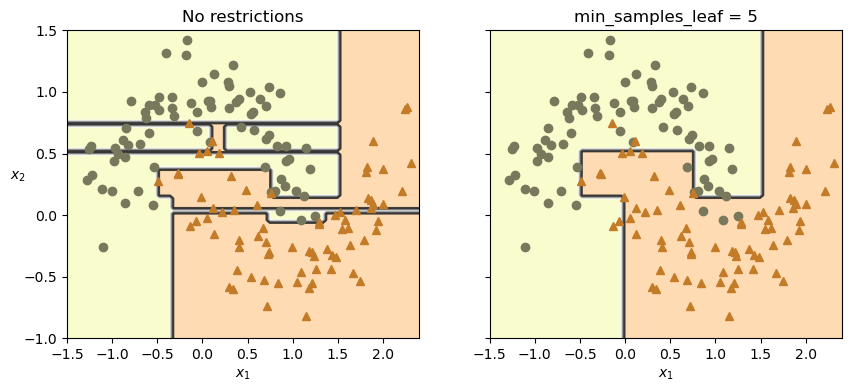

In [5]:
from sklearn.datasets import make_moons

X_moons, y_moons = make_moons(n_samples=150, noise=0.2, random_state=42)

tree_clf1 = DecisionTreeClassifier(random_state=42)
tree_clf2 = DecisionTreeClassifier(min_samples_leaf=5, random_state=42)
tree_clf1.fit(X_moons, y_moons)
tree_clf2.fit(X_moons, y_moons)


def plot_decision_boundary(clf, X, y, axes, cmap):
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=cmap)
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8)
    colors = {"Wistia": ["#78785c", "#c47b27"], "Pastel1": ["red", "blue"]}
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[cmap][idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf1, X_moons, y_moons,
                       axes=[-1.5, 2.4, -1, 1.5], cmap="Wistia")
plt.title("No restrictions")
plt.sca(axes[1])
plot_decision_boundary(tree_clf2, X_moons, y_moons,
                       axes=[-1.5, 2.4, -1, 1.5], cmap="Wistia")
plt.title(f"min_samples_leaf = {tree_clf2.min_samples_leaf}")
plt.ylabel("")

plt.show()

# 8.회귀 
- `DecisionTreeRegressor` 클래스를 사용해 회귀 트리 생성

## 분류와 회귀의 차이 
- 회귀는 분류와 다르게 `값 예측`을 한다는 점 
- 각 영역의 예측 값은 그 영역의 `타깃 값의 평균`

- 예시 : 2차 함수 형태 데이터 셋을 결정 트리로 회귀

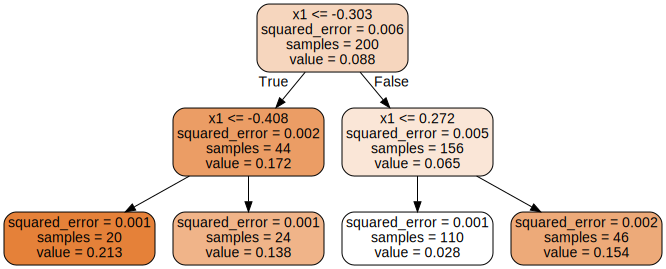

In [8]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

### 랜덤 데이터 생성 
np.random.seed(42)
X_quad = np.random.rand(200, 1) - 0.5  # 간단한 랜덤한 입력 특성
y_quad = X_quad ** 2 + 0.025 * np.random.randn(200, 1)

### 트리 생성 
tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
### 모델 학습
tree_reg.fit(X_quad, y_quad)

export_graphviz(
    tree_reg,
    out_file=str( "regression_tree.dot"),
    feature_names=["x1"],
    rounded=True,
    filled=True
)
Source.from_file( "regression_tree.dot")

- $x_1=0.2$ 인 경우 
- `value - 0.028`을 예측으로 사용 
- 예측값의 평균 제곱 오차 (MSE) : 0.015

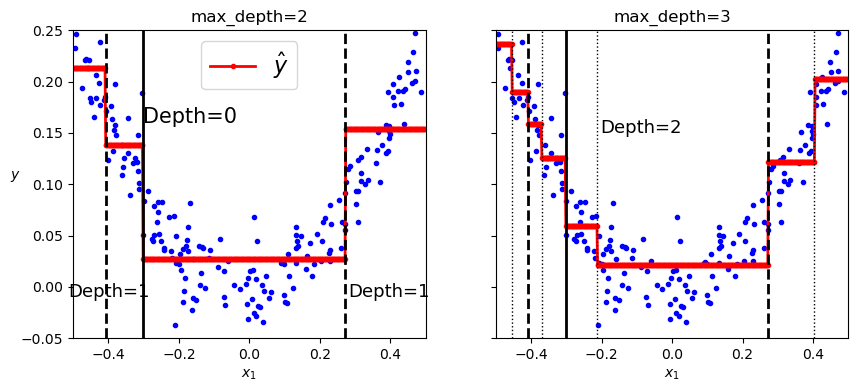

In [9]:
tree_reg2 = DecisionTreeRegressor(max_depth=3, random_state=42)
tree_reg2.fit(X_quad, y_quad)

def plot_regression_predictions(tree_reg, X, y, axes=[-0.5, 0.5, -0.05, 0.25]):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$")
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg, X_quad, y_quad)

th0, th1a, th1b = tree_reg.tree_.threshold[[0, 1, 4]]
for split, style in ((th0, "k-"), (th1a, "k--"), (th1b, "k--")):
    plt.plot([split, split], [-0.05, 0.25], style, linewidth=2)
plt.text(th0, 0.16, "Depth=0", fontsize=15)
plt.text(th1a + 0.01, -0.01, "Depth=1", horizontalalignment="center", fontsize=13)
plt.text(th1b + 0.01, -0.01, "Depth=1", fontsize=13)
plt.ylabel("$y$", rotation=0)
plt.legend(loc="upper center", fontsize=16)
plt.title("max_depth=2")

plt.sca(axes[1])
th2s = tree_reg2.tree_.threshold[[2, 5, 9, 12]]
plot_regression_predictions(tree_reg2, X_quad, y_quad)
for split, style in ((th0, "k-"), (th1a, "k--"), (th1b, "k--")):
    plt.plot([split, split], [-0.05, 0.25], style, linewidth=2)
for split in th2s:
    plt.plot([split, split], [-0.05, 0.25], "k:", linewidth=1)
plt.text(th2s[2] + 0.01, 0.15, "Depth=2", fontsize=13)
plt.title("max_depth=3")

plt.show()

### CART 알고리즘의 역할 
- 분류 : 훈련세트의 불순도를 최소화
- 회귀 : 훈련세트의 평균 제곱 오차를 최소화


### 과대적합 문제 
- 규제가 없으면 회귀에서도 결정트리가 과대적합되기 쉬움 

- 예시 : 규제 없음 VS 규제 있음 

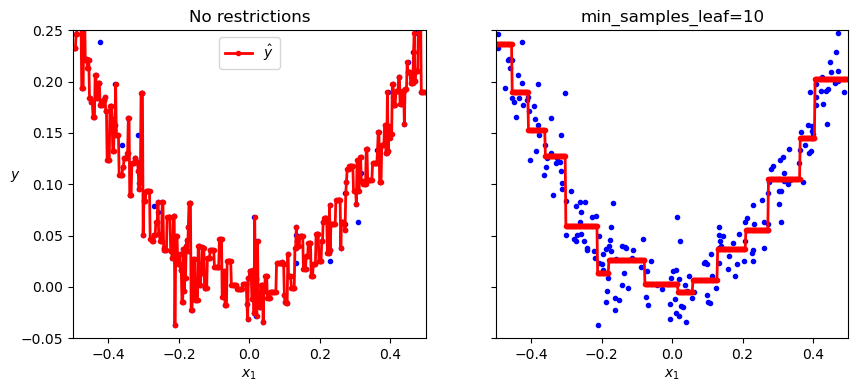

In [10]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X_quad, y_quad)
tree_reg2.fit(X_quad, y_quad)

x1 = np.linspace(-0.5, 0.5, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plt.plot(X_quad, y_quad, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([-0.5, 0.5, -0.05, 0.25])
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.legend(loc="upper center")
plt.title("No restrictions")

plt.sca(axes[1])
plt.plot(X_quad, y_quad, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([-0.5, 0.5, -0.05, 0.25])
plt.xlabel("$x_1$")
plt.title(f"min_samples_leaf={tree_reg2.min_samples_leaf}")

plt.show()

# 9. 축 방향의 민감성 
- 결정 트리 모델은 `결정 경계`를 `계단 모양`으로 생성 
- 따라서 데이터의 방향에 민감함 

- 예시 : 동일한 데이터를 45도 회전 한 데이터 

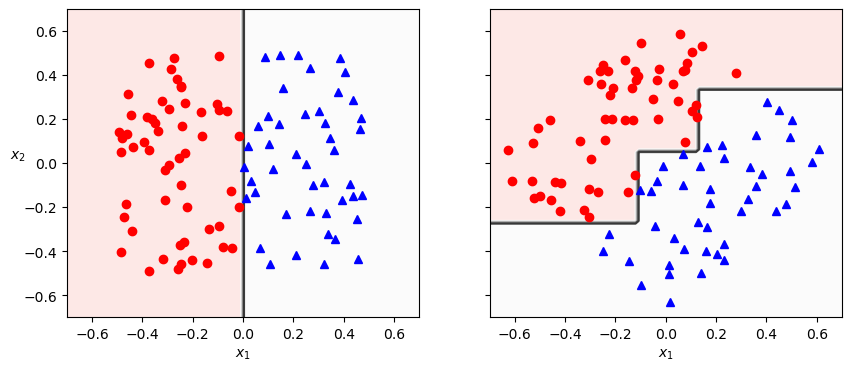

In [11]:
np.random.seed(6)
X_square = np.random.rand(100, 2) - 0.5
y_square = (X_square[:, 0] > 0).astype(np.int64)

angle = np.pi / 4  # 45 도
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                            [np.sin(angle), np.cos(angle)]])
X_rotated_square = X_square.dot(rotation_matrix)

tree_clf_square = DecisionTreeClassifier(random_state=42)
tree_clf_square.fit(X_square, y_square)
tree_clf_rotated_square = DecisionTreeClassifier(random_state=42)
tree_clf_rotated_square.fit(X_rotated_square, y_square)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf_square, X_square, y_square,
                       axes=[-0.7, 0.7, -0.7, 0.7], cmap="Pastel1")
plt.sca(axes[1])
plot_decision_boundary(tree_clf_rotated_square, X_rotated_square, y_square,
                       axes=[-0.7, 0.7, -0.7, 0.7], cmap="Pastel1")
plt.ylabel("")
plt.show()

## 방향성 해결 방법 
- 스케일 조정 + `주성분 분석(PCA)`

### 주성분 분석(PCA)
- 특성간 상관관계를 줄이는 방식으로 데이터를 회전하여 결정트리를 쉽게 만듦 

- 예시 : PCA를 통한 주성분 분석 

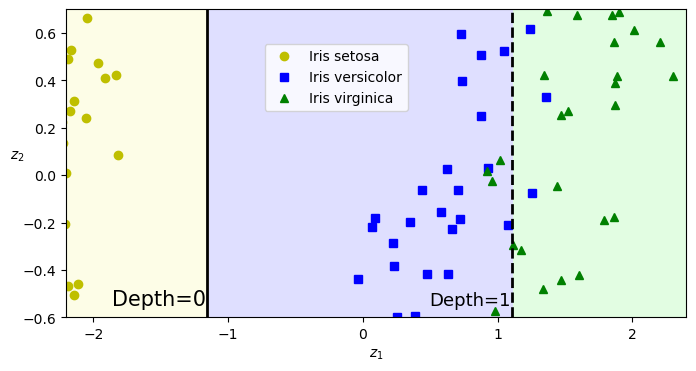

In [13]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pca_pipeline = make_pipeline(StandardScaler(), PCA(n_components=2))
X_iris_rotated = pca_pipeline.fit_transform(iris.data)
tree_clf_pca = DecisionTreeClassifier(random_state=42, max_depth=2)
tree_clf_pca.fit(X_iris_rotated, y_iris)

plt.figure(figsize=(8, 4))

axes = [-2.2, 2.4, -0.6, 0.7]
z0s, z1s = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                       np.linspace(axes[2], axes[3], 100))
X_iris_pca_all = np.c_[z0s.ravel(), z1s.ravel()]
y_pred = tree_clf_pca.predict(X_iris_pca_all).reshape(z0s.shape)

plt.contourf(z0s, z1s, y_pred, alpha=0.3, cmap=custom_cmap)
for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(X_iris_rotated[:, 0][y_iris == idx],
             X_iris_rotated[:, 1][y_iris == idx],
             style, label=f"Iris {name}")

plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
th1, th2 = tree_clf_pca.tree_.threshold[[0, 2]]
plt.plot([th1, th1], axes[2:], "k-", linewidth=2)
plt.plot([th2, th2], axes[2:], "k--", linewidth=2)
plt.text(th1 - 0.01, axes[2] + 0.05, "Depth=0",
         horizontalalignment="right", fontsize=15)
plt.text(th2 - 0.01, axes[2] + 0.05, "Depth=1",
         horizontalalignment="right", fontsize=13)
plt.axis(axes)
plt.legend(loc=(0.32, 0.67))

plt.show()

In [ ]:
# 10. 결정트리의 분산 문제 
- 결정트리는 단점 중 하나는 `분산`이 큼
- 하이퍼파라미터나 데이터를 조금만 변경해도 `매우` 다른 모델이 만들어짐 
- 해결 방법 : 여러 결정 트리를 만들어 분산을 크게 줄일 수 있음 
-> `랜덤 포레스트` 방식이라고 불림 